In [1]:
import csv

from itertools import product, zip_longest

import numpy as np

import os

import pandas as pd

import sys

import torch

from tqdm import tqdm

from Reordering_Swapping_for_GPU import parameter_swap_same_tensor

from makeSignals import myTrueModel, myNoisyModel, myTrueModel_2param

from regTraj import least_squares_2param, least_squares_3param, curve_fit_2param, make_l2_trajectory

from writeParams import writeSummary

# ===============================================================================#

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
# What signal-to-noise ratio should be used?

#Insert Signal to Noise To Be Tested
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
SNR = 900.0
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#Ensure either GPU or CPU is being used.  Alter cuda:(#) to ensure correct device is running
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

# Where should the data be saved?
#Change the directory if needed to ensure folder setup is sufficient (see word doc on directory configuration)
dataDir = './_results/_dataSets/_snr' + str(int(SNR)) + '/'

# Is the data used for Training, Testing, Validation, or otherwise?
#Use key words Training, Testing, or Validation.  One of each should be run for each dataset.
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dataPurpose = 'Validation'
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#Change file name with apropriate experiment title, SNR value, Training Range, Testing Range, 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dataDescription = 'Week12_SNR900_lambdaneg4_NDNDvNDB'

#NDNDvNDB_Noise_And_Big_File_Jonathan_SNR_1__Training_Range_50_500_Test_75_475_L_10_neg1_NT_64_NLLS_constraints
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


thisDatasName = dataDescription + '_' + dataPurpose + 'Data.csv'

# Should targets be chosen randomly or exhaustively (i.e., all possible...

# ...targets appear in the dataset.)

# Choices are 'random' or 'exhaustive'

targetSelection = 'exhaustive'

# How many triplets should be constructed used? How many noise realizations

# per triplet?


#Noise Realizations are white noise.  More noise realizations can increase runtimes.  Recommended values are default.
if targetSelection is 'random':

    if dataPurpose is 'Training':

        num_triplets, noise_realizations = 6250, 250

    elif dataPurpose is 'Validation':

        num_triplets, noise_realizations = 20000, 1

    elif dataPurpose is 'Testing':

        num_triplets, noise_realizations = 50000, 1

    else:

        num_triplets, noise_realizations = 10, 3

    num_samples = num_triplets * noise_realizations


#Noise Realizations are white noise.  More noise realizations can increase runtimes.  Recommended values are listed.
elif targetSelection is 'exhaustive':

    if dataPurpose is 'Training':

        noise_realizations = 250

    elif dataPurpose is 'Validation':

        noise_realizations = 10

    elif dataPurpose is 'Testing':

        noise_realizations = 20

    else:

        noise_realizations = 100

    # num_samples depends on how finely spaced the parameter space is

# Any particular notes regarding the construction of this data set?

notes = 'The target value of c1 is fixed at 0.6.'

Running on the GPU


<>:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipy

In [6]:
##------------------------------##

##    Define Parameter Space    ##

##------------------------------##

num_params = 2 
# in otherwords we are adding two decays
# Think of this as a function y(x) = SUM[1-->n]: (c_n)(e)^((t1n)(x))  

dataType = np.float64

print('----  Initializing parameters  ----')

#=======================================================================
# A) initial fraction of components
#=======================================================================

# ----------------------------------

if num_params == 2:

    c1 = 0.6

    c2 = 0.4



elif num_params == 3:

    num_c1 = 50

    c1_low = 0.5 #we set a low and high value to know a general range

    c1_high = 0.7

    # c1 = np.linspace(c1_low, c1_high, num_c1, dtype=dataType)

    c1 = 0.6 * np.ones(num_c1, dtype=dataType) 
    #returns an array filled with 1s of the same size as num_c1

#=======================================================================
# B1) T2 parameters
#=======================================================================

# -----------------

num_T21 = 50  # number of T2,1 parameters to choose from

if dataPurpose == "Testing":
    T21_low, T21_high = 75.0, 475.0  # lower, upper bound on T2,1

    num_T22, T22_low, T22_high = 50, 75.0, 475.0

elif dataPurpose == "Validation":
    T21_low, T21_high = 75.0, 475.0  # lower, upper bound on T2,1

    num_T22, T22_low, T22_high = 50, 75.0, 475.0
    
else:
    T21_low, T21_high = 50.0, 500.0  # lower, upper bound on T2,1

    num_T22, T22_low, T22_high = 50, 50.0, 500.0
    
T21 = np.linspace(T21_low, T21_high, num_T21, dtype=dataType)
#list now goes from low value to high value with number of steps equal to num_T2n

# T21 = np.array([50.0], dtype=dataType)

T22 = np.linspace(T22_low, T22_high, num_T22, dtype=dataType)
#list now goes from low value to high value with number of steps equal to num_T2n

# T22 = np.array([426.53], dtype=dataType)

# B2) NLLS Parameters

NLLS_T21_lb = 50.0
NLLS_T21_ub = 50.0
NLLS_T22_lb = 500.0
NLLS_T22_ub = 500.0

#=======================================================================
# C) Acquisition times, SNR, signal type
#=======================================================================

# ---------------------------------------

num_times = 64  # number of signal acquisition times

time_low, time_high = 0.0, 1.6 * T22_high

time = np.linspace(time_low, time_high, num_times, dtype=dataType)

mySignalType = "biexponential"

#=======================================================================
# D) Nonlinear Least Squares (NLLS) params
#=======================================================================

# -----------------------------------------

#...............................
# D.1) Regularization paramsda
#...............................

#NUMBER OF LAMBDAS BEING COMBINED
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
traj_len = 1  # (number of lambdas) "length" of the regularization trajectory
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# Estimate neighborhood of regularization parameter using discrepancy principle

delta = np.sqrt(np.double(num_times) / SNR)  # approx. model error due to noise

start_exp_shift = -7.0

end_exp_shift = 3.0

# reg_params = np.logspace(start=np.log10(delta) + start_exp_shift,

#                          stop=np.log10(delta) + end_exp_shift,

#                          num=traj_len,

#                          dtype=dataType)

#LAMBDA VALUES SHOULD EXIST IN BELOW LIST
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
reg_params = np.array([1.6e-4], dtype=dataType)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


#...............................
# D.2) Weights in penalty term
#...............................

if num_params == 2:
    D = np.array([1.0,  # T2,1

                  1.0])  # T2,2

if num_params == 3:
    D = np.array([150.0,  # c1

                  1.0,  # T2,1

                  1.0])  # T2,2

#...............................
# D.3) Initial guess for NLLS solver
#...............................

if num_params == 2:
    T21_0 = (T21_low + T21_high) / 2.0

    T22_0 = (T22_low + T22_high) / 2.0

    p_0 = np.array([T21_0, T22_0])

if num_params == 3:
    c1_0 = (c1_low + c1_high) / 2.0

    T21_0 = (T21_low + T21_high) / 2.0

    T22_0 = (T22_low + T22_high) / 2.0

    p_0 = np.array([c1_0, T21_0, T22_0])

# What NLLS solver do you want to use?

# options: scipy_curve_fit or scipy_least_squares

theSolver = "scipy_curve_fit"


#...............................
# D.4) How many signals do we allow to be 'trivial'?
#...............................


#      Which signals are nontrivial?

frac_trivial_tol = 1.0  # Max fraction of reconstructed signals that are...

# ...'identical' to the 'trivial signal'

frac_error_tol = 1.1  # A reconstructed signal is 'different' from 'trivial' if:

#   (model error) <= error_tol*(trivial model error)

#=======================================================================
# E) Make Parameter Training/Testing Samples
#=======================================================================

# -------------------------------------------

#...............................
# E.1) Choose seed
#...............................

if dataPurpose is 'Training':

    seed = 73

elif dataPurpose is 'Testing':

    seed = 3700

elif dataPurpose is 'Validation':

    seed = 100000

else:

    seed = 852

#...............................
# E.2) Set seed
#...............................

np.random.seed(seed)

#...............................
# E.3) Choose samples
#...............................

if num_params == 2:

    if targetSelection is 'random': #Note that the random model randomly selects a value for T2n between 0 and len_T2n and composes some triplets within
        c1_target = c1

        c2_target = c2

        T21_target = T21[np.random.randint(low=0, high=len(T21), size=(num_triplets,))]

        T22_target = T22[np.random.randint(low=0, high=len(T22), size=(num_triplets,))]



    elif targetSelection is 'exhaustive':

        c1_target, c2_target, T21_target, T22_target = c1, c2, T21, T22

        # Use np.unique first. Useful for the case where a target parameter is fixed.

        num_triplets = len(np.unique(c1)) * len(np.unique(T21)) * len(np.unique(T22))

        num_samples = num_triplets * noise_realizations



elif num_params == 3:

    if targetSelection is 'random':

        c1_target = c1[np.random.randint(low=0, high=len(c1), size=(num_triplets,))]

        T21_target = T21[np.random.randint(low=0, high=len(T21), size=(num_triplets,))]

        T22_target = T22[np.random.randint(low=0, high=len(T22), size=(num_triplets,))]



    elif targetSelection is 'exhaustive':

        c1_target, T21_target, T22_target = c1, T21, T22

        # Use np.unique first. Useful for the case where a target parameter is fixed.

        num_triplets = len(np.unique(c1)) * len(np.unique(T21)) * len(np.unique(T22))

        num_samples = num_triplets * noise_realizations

print(num_triplets)
print(noise_realizations)
print(num_samples)

----  Initializing parameters  ----
2500
10
25000


<>:202: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:210: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:230: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:265: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:202: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:210: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:230: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:241: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:265: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_21424/2854419833.py:202: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataPurpose is 'Tr

In [7]:
##----------------------------------------##

##    Make Regularization Trajectories    ##

##----------------------------------------##


# A) Init. data frame to store data and targets for each sample

# --------------------------------------------------------------

if num_params == 2:

    trajectory_features = ['reg_params',

                           'c1_traj',

                           'T21_traj',

                           'T22_traj',

                           'RNLLS_NLLS_Error_Sum',

                           'RNLLS_NLLS_Error_Max',

                           'rel_model_error',

                           'c1_nlls',

                           'T21_nlls',

                           'T22_nlls',

                           'rel_model_error_nlls',

                           'c1_target',

                           'c2_target',

                           'T21_target',

                           'T22_target',

                           'noisy_decay']



elif num_params == 3:

    trajectory_features = ['reg_params',

                           'c1_traj',

                           'T21_traj',

                           'T22_traj',

                           'RNLLS_NLLS_Error_Sum',

                           'RNLLS_NLLS_Error_Max',

                           'rel_model_error',

                           'c1_nlls',

                           'T21_nlls',

                           'T22_nlls',

                           'rel_model_error_nlls',

                           'c1_target',

                           'T21_target',

                           'T22_target',

                           'noisy_decay']

# each row of the data frame is a separate sample.

# each column is a separate feature.

training_data_frame = pd.DataFrame(columns=trajectory_features)

list_of_samples = list(range(0, num_samples))

# B) Calculate trivial signal's model error

# ------------------------------------------

# B) Calculate trivial signal's model error

# ------------------------------------------

trivial_signal = myTrueModel(time,

                             1e-10, 1e-10, 1e-10,  # parameters all 'zero'

                             signalType=mySignalType)

# Construct iterable containing targets and sample index

if num_params == 2:

    if targetSelection is 'random':

        triplets = zip((c1_target, c2_target), T21_target, T22_target)

    elif targetSelection is 'exhaustive':

        # Makes the Cartesian product of all the target values.

        # Creates all possible triplets.

        triplets = product((c1_target,), T21_target, T22_target)

if num_params == 3:

    if targetSelection is 'random':

        triplets = zip(c1_target, T21_target, T22_target)

    elif targetSelection is 'exhaustive':

        # Makes the Cartesian product of all the target values.

        # Creates all possible triplets.

        triplets = product(c1_target, T21_target, T22_target)


target_iterator = zip(triplets, range(0, num_triplets))

# sample with max pointwise deviation between RNLLS and NLLS signals

worst_sample_idx = 0

max_ptws_error = 0.0


for (c_t, T21_t, T22_t), j in tqdm(target_iterator, total = len(range(0, num_triplets))):  # each j is one target sample  # each j is one target sample

        c1_t = c_t

        c2_t = 1.0 - c1_t

        # Swapping target values. Enforces T21 <= T22.

        if T21_t > T22_t:
            new_T22 = T21_t

            new_T21 = T22_t

            T21_t = new_T21

            T22_t = new_T22

        for k in range(noise_realizations):

            sample_idx = j * noise_realizations + k
            sample_idx
            
            
            #print(f'-- Starting (triplet, noise realization)=({j + 1},{k + 1}) of ({num_triplets},{noise_realizations})'+ f'\n\t[sample {sample_idx + 1} of {num_samples}]')

            # A) Init. containers for reconstructed signals and L-curve

            # ----------------------------------------------------------

            model_error = np.zeros(traj_len)  # ||G(p_ld) - d||_2

            model_error_d = torch.zeros(traj_len)  # ||G(p_ld) - d||_2/||d||_2

            # make a signal for the corresponding parameter set

            if num_params == 2:

                true_signal = myTrueModel_2param(time, c1_t, c2_t, T21_t, T22_t, signalType=mySignalType)



            elif num_params == 3:

                true_signal = myTrueModel(time, c1_t, T21_t, T22_t, signalType=mySignalType)

            # add noise to the signal

            noisy_signal = myNoisyModel(true_signal, SNR, signalType=mySignalType)

            # calculate trivial signal's relative model error

            norm_d = np.linalg.norm(noisy_signal)

            trivial_model_error_d = np.linalg.norm(trivial_signal

                                                   - noisy_signal) / norm_d

            error_tol = frac_error_tol * trivial_model_error_d  # tolerate some fraction of the trivial...

            # ...signal's model error

            # # Refresh regularization parameters

            # start_exp_shift = -7.0

            # end_exp_shift = 3.0

            # reg_params = np.logspace(start=np.log10(delta) + start_exp_shift,

            #                          stop=np.log10(delta) + end_exp_shift,

            #                          num=traj_len,

            #                          dtype=dataType)

            # C) Iteratively construct regularization trajectories until a sufficient

            #      fraction of reconstructed signals differs from the 'trivial signal',

            #      i.e., parameters all zero.

            # --------------------------------------------------------------------------

            num_trivial = 0  # number of 'trivial' reconstructed signals

            frac_trivial_recon = 1.0  # fraction of reconstructed signals that are 'trivial'

            new_sample_data_frame = pd.DataFrame(columns=trajectory_features)

            if num_params == 2:

                while frac_trivial_recon >= frac_trivial_tol:

                    # 1. Make regularization trajectories

                    #        print(f'\t\t....Making regularization trajectories for sample {j+1} of {num_samples}')

                    T21_ld, T22_ld = make_l2_trajectory(time,

                                                        noisy_signal,

                                                        reg_params,

                                                        c1_t,

                                                        c2_t,

                                                        p_0,  # initial guess

                                                        D,  # weights

                                                        solver=theSolver,

                                                        lb_T21=50.0, lb_T22=50.0, ub_T21=500.0, ub_T22=500.0)

                    c1_ld = c1_t * torch.ones(len(T21_ld))

                    # 2. Reconstruct signals and calculate their normalized model error

                    #       print('\t\t....Reconstructing signals')

                    for t21, t22, m in zip(T21_ld, T22_ld, range(0, traj_len)):

                        recon_signal = myTrueModel_2param(time, c1_t, c2_t, t21, t22, signalType=mySignalType)

                        model_error[m] = np.linalg.norm(recon_signal - noisy_signal)

                        model_error_d[m] = model_error[m] / norm_d

                        if model_error_d[m] > error_tol: num_trivial += 1

                    # 3. Calculate the fraction of 'trivial' reconstructed signals

                    frac_trivial_recon = num_trivial / traj_len

                    #        print(f'\t\t\t-- fraction of trivial reconstructed signals v.s. allowed trivial: ' +

                    #              f'{frac_trivial_recon} v.s. {frac_trivial_tol}')

                    # 4. Decrease largest regularization parameter

                    if frac_trivial_recon >= frac_trivial_tol:

                        end_exp_shift -= 0.1

                        if end_exp_shift <= start_exp_shift: end_exp_shift += 0.09

                        reg_params = np.logspace(start=np.log10(delta) + start_exp_shift, stop=np.log10(delta) + end_exp_shift, num=traj_len)

                    #        print(f'\t\t\t-- The regularization parameters are: \n\t\t\t\t{reg_params}')

                    num_trivial = 0

                # end while



            elif num_params == 3:

                while frac_trivial_recon >= frac_trivial_tol:

                    # 1. Make regularization trajectories

                    #        print(f'\t\t....Making regularization trajectories for sample {j+1} of {num_samples}')

                    c1_ld, T21_ld, T22_ld = make_l2_trajectory(time,

                                                               noisy_signal,

                                                               reg_params,

                                                               c1_t,

                                                               c2_t,

                                                               p_0,  # initial guess

                                                               D,  # weights

                                                               solver=theSolver)

                    # 2. Reconstruct signals and calculate their normalized model error

                    #       print('\t\t....Reconstructing signals')

                    for c, t21, t22, m in zip(c1_ld, T21_ld, T22_ld, range(0, traj_len)):

                        recon_signal = myTrueModel(time,c, t21, t22, signalType=mySignalType)

                        model_error[m] = np.linalg.norm(recon_signal - noisy_signal)

                        model_error_d[m] = model_error[m] / norm_d

                        if model_error_d[m] > error_tol: num_trivial += 1

                    # 3. Calculate the fraction of 'trivial' reconstructed signals

                    frac_trivial_recon = num_trivial / traj_len

                    #        print(f'\t\t\t-- fraction of trivial reconstructed signals v.s. allowed trivial: ' +

                    #              f'{frac_trivial_recon} v.s. {frac_trivial_tol}')

                    # 4. Decrease largest regularization parameter

                    if frac_trivial_recon >= frac_trivial_tol:

                        end_exp_shift -= 0.1

                        if end_exp_shift <= start_exp_shift: end_exp_shift += 0.09

                        reg_params = np.logspace(start=np.log10(delta) + start_exp_shift,stop=np.log10(delta) + end_exp_shift, num=traj_len)

                    #        print(f'\t\t\t-- The regularization parameters are: \n\t\t\t\t{reg_params}')

                    num_trivial = 0

                # end while

                # D) Get NLLS solution with no regularization

                # --------------------------------------------

            if num_params == 2:

                if theSolver is "scipy_least_squares":

                    T21_NLLS, T22_NLLS = least_squares_2param(myTrueModel_2param, noisy_signal, time, c1_t, c2_t, p_0)

                elif theSolver is "scipy_curve_fit":

                    T21_NLLS, T22_NLLS = curve_fit_2param(noisy_signal, time, c1_t, c2_t, p_0, lb_T21=50.0, lb_T22=50.0, ub_T21=500.0, ub_T22=500.0)

                recon_signal = myTrueModel_2param(time, c1_t, c2_t, T21_NLLS, T22_NLLS, signalType=mySignalType)

                model_error_d_NLLS = np.linalg.norm(recon_signal - noisy_signal) / norm_d

                c1_NLLS = c1_t



            elif num_params == 3:

                if theSolver is "scipy_least_squares":
                    c1_NLLS, T21_NLLS, T22_NLLS = least_squares_3param(myTrueModel,

                                                                       noisy_signal,

                                                                       time,

                                                                       p_0)

                recon_signal = myTrueModel(time, c1_NLLS, T21_NLLS, T22_NLLS, signalType=mySignalType)

                model_error_d_NLLS = np.linalg.norm(recon_signal - noisy_signal) / norm_d

            # calculate pointwise deviation between RNllS and NLLS signals

            # -------------------------------------------------------------

            if num_params == 2:

                # max pointwise difference

                RNLLS_NLLS_Error_Max = torch.zeros(traj_len)

                # sum of absolute pointwise errors

                RNLLS_NLLS_Error_Sum = torch.zeros(traj_len)

                # loop over regularization parameters

                for tau_1, tau_2, l in zip(T21_ld, T22_ld, range(0, traj_len)):

                    RNLLS_decay_points = myTrueModel_2param(time, c1_t, c2_t, tau_1, tau_2, signalType=mySignalType)

                    NLLS_decay_points = myTrueModel_2param(time, c1_t, c2_t, T21_NLLS, T22_NLLS, signalType=mySignalType)

                    R_minus_N_points = torch.abs(RNLLS_decay_points - NLLS_decay_points)

                    RNLLS_NLLS_Error_Max[l] = torch.max(R_minus_N_points).item()

                    RNLLS_NLLS_Error_Sum[l] = torch.sum(R_minus_N_points).item()

                    if RNLLS_NLLS_Error_Max[l] > max_ptws_error:
                        max_ptws_error = RNLLS_NLLS_Error_Max[l]

                        worst_sample_idx = sample_idx

                        #print(f'New worst sample: {sample_idx}' + f'\n\t\t-> max ptws error: {RNLLS_NLLS_Error_Max[l]}' + f'\n\t\t-> lambda: {reg_params[l]}')

            # Swapping.

            # ----------

            # empty numpy array [x, x, x, x, x]

            # T21_np = np.empty([1, traj_len])

            # T22_np = np.empty([1, traj_len])

            # empty lists to store T21, T22, and c1

            T21_list = []

            T22_list = []

            c1_list = []

            # Swapping for regularization trajectories. Enforces T21 <= T22.

            for i in range(0, traj_len):  # gives index for every member of trajectory

                if T21_ld[i] > T22_ld[i]:

                    T21_new = T22_ld[i].numpy().tolist()

                    T21_list.append(T21_new)

                    T22_new = T21_ld[i].numpy().tolist()

                    T22_list.append(T22_new)

                    c1_ld[i] = 1.0 - c1_ld[i]

                    c1_list.append(c1_ld[i].tolist())



                else:

                    T21_list.append(T21_ld[i].tolist())

                    T22_list.append(T22_ld[i].tolist())

                    c1_list.append(c1_ld[i].tolist())

            # make list into a Numpy array

            T21_np = np.asarray(T21_list)

            T22_np = np.asarray(T22_list)

            c1_np = np.asarray(c1_list)

            # make Numpy array into a Tensor

            T21_ld = torch.from_numpy(T21_np)

            T22_ld = torch.from_numpy(T22_np)

            c1_ld = torch.from_numpy(c1_np)

            # Swapping or NLLS results. Enforces T21 <= T22.

            if T21_NLLS > T22_NLLS:
                new_T21_NLLS = T22_NLLS

                new_T22_NLLS = T21_NLLS

                T21_NLLS = new_T21_NLLS

                T22_NLLS = new_T22_NLLS

                new_c1_NLLS = 1.0 - c1_NLLS

                c1_NLLS = new_c1_NLLS

                c2_NLLS = 1.0 - c1_NLLS

            # E) Store the regularization trajectories for this sample

            # --------------------------------------------------------

            new_sample_data_frame['reg_params'] = [reg_params]

            new_sample_data_frame['c1_traj'] = [c1_ld]

            new_sample_data_frame['T21_traj'] = [T21_ld]

            new_sample_data_frame['T22_traj'] = [T22_ld]

            new_sample_data_frame['RNLLS_NLLS_Error_Sum'] = [RNLLS_NLLS_Error_Sum]

            new_sample_data_frame['RNLLS_NLLS_Error_Max'] = [RNLLS_NLLS_Error_Max]

            new_sample_data_frame['rel_model_error'] = [model_error_d]

            new_sample_data_frame['c1_nlls'] = c1_NLLS

            new_sample_data_frame['T21_nlls'] = T21_NLLS

            new_sample_data_frame['T22_nlls'] = T22_NLLS

            new_sample_data_frame['rel_model_error_nlls'] = model_error_d_NLLS

            new_sample_data_frame['c1_target'] = c1_t

            if num_params == 2: new_sample_data_frame['c2_target'] = c2_t

            new_sample_data_frame['T21_target'] = T21_t

            new_sample_data_frame['T22_target'] = T22_t

            new_sample_data_frame['noisy_decay'] = [torch.Tensor(noisy_signal)]

            list_of_samples[sample_idx] = new_sample_data_frame
            
            counter = sample_idx+1
            
    # end for


training_data_frame = pd.concat(list_of_samples, ignore_index=True)
print('hi!')

<>:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:120: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:124: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:367: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:371: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:385: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:120: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:124: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:367: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:371: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:385: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_21424/3396622441.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if targetSelection is

hi!


The worst index from the loop is 492
reg_params                                                      [0.00016]
c1_traj                             [tensor(0.4000, dtype=torch.float64)]
T21_traj                               [tensor(50., dtype=torch.float64)]
T22_traj                          [tensor(324.4260, dtype=torch.float64)]
RNLLS_NLLS_Error_Sum                                     [tensor(1.2192)]
RNLLS_NLLS_Error_Max                                     [tensor(0.0337)]
rel_model_error                                          [tensor(0.1108)]
c1_nlls                                                               0.6
T21_nlls                                                        69.388986
T22_nlls                                                       493.239324
rel_model_error_nlls                                             0.086756
c1_target                                                             0.6
c2_target                                                             0.4
T

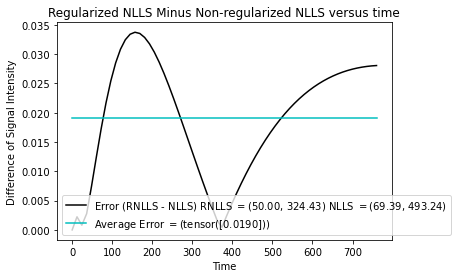

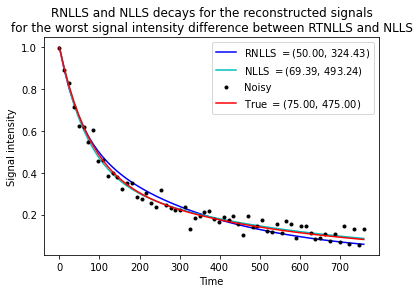

In [8]:
##---------------------------------##

##    Graph Error Sums and Maxs    ##

##---------------------------------##


# 1. Sum of Absolute Error


import matplotlib.pyplot as plt

pd.set_option("display.max_rows", None, "display.max_columns", None)

Sums = training_data_frame["RNLLS_NLLS_Error_Sum"]

Maxes = training_data_frame["RNLLS_NLLS_Error_Max"]

print(f'The worst index from the loop is {worst_sample_idx}')

# max_index = Maxes.idxmax()

# print(max_index)


MaxRow = training_data_frame.iloc[worst_sample_idx, :]

print(MaxRow)

worst_c1_traj = MaxRow.loc["c1_traj"]

worst_T21_traj = MaxRow.loc["T21_traj"]

worst_T22_traj = MaxRow.loc["T22_traj"]

worst_decay_error = MaxRow.loc["RNLLS_NLLS_Error_Max"]

max_error, max_idx = torch.max(worst_decay_error, dim=0)

if max_error == max_ptws_error:
    print(f'Successfully found worst sample in frame. Error: {max_error}')

else:
    print('Failed to find worst sample in frame')

WorstRNLLSdecay = myTrueModel_2param(time, worst_c1_traj[max_idx], 1.0 - worst_c1_traj[max_idx], worst_T21_traj[max_idx], worst_T22_traj[max_idx], signalType=mySignalType)

WorstNLLSdecay = myTrueModel_2param(time, MaxRow.loc["c1_nlls"], 1.0 - MaxRow.loc["c1_nlls"], MaxRow.loc["T21_nlls"], MaxRow.loc["T22_nlls"], signalType=mySignalType)

WorstTruedecay = myTrueModel_2param(time, MaxRow.loc["c1_target"], 1.0 - MaxRow.loc["c1_target"], MaxRow.loc["T21_target"], MaxRow.loc["T22_target"], signalType=mySignalType)

# Error per time


plt.figure(1)

plt.plot(time, torch.abs(WorstRNLLSdecay - WorstNLLSdecay), 'k-',

         time, torch.ones(len(time)) * (MaxRow.loc["RNLLS_NLLS_Error_Sum"][max_idx] / len(time)), 'c-', )

plt.title('Regularized NLLS Minus Non-regularized NLLS versus time')

plt.xlabel('Time');
plt.ylabel('Difference of Signal Intensity')

plt.legend([
    f'Error (RNLLS - NLLS) RNLLS $=(${worst_T21_traj[max_idx].item():.2f}, {worst_T22_traj[max_idx].item():.2f}$)$ NLLS $=(${MaxRow.loc["T21_nlls"]:.2f}, {MaxRow.loc["T22_nlls"]:.2f}$)$',

    f'Average Error $=(${(MaxRow.loc["RNLLS_NLLS_Error_Sum"] / len(time))}$)$'])

# MAX decay graph


plt.figure(2)

plt.plot(time, WorstRNLLSdecay, 'b-')

plt.plot(time, WorstNLLSdecay, 'c-')

plt.plot(time, MaxRow.loc["noisy_decay"], 'k.')

plt.plot(time, WorstTruedecay, 'r-')

plt.title(
    'RNLLS and NLLS decays for the reconstructed signals\nfor the worst signal intensity difference between RTNLLS and NLLS')

plt.xlabel('Time');
plt.ylabel('Signal intensity')

plt.legend([f'RNLLS $=(${worst_T21_traj[max_idx].item():.2f}, {worst_T22_traj[max_idx].item():.2f}$)$',

            f'NLLS $=(${MaxRow.loc["T21_nlls"]:.2f}, {MaxRow.loc["T22_nlls"]:.2f}$)$',

            'Noisy',

            f'True $=(${MaxRow.loc["T21_target"]:.2f}, {MaxRow.loc["T22_target"]:.2f}$)$'])

# plt.show()

In [10]:
##---------------------##

##    Write Results    ##

##---------------------##

print('----  Writing File  ----')

# Save data set to a csv. Not readable for humans

# ------------------------------------------------

torch.save(training_data_frame, dataDir + thisDatasName)

# Write the worst sample's data

# ------------------------------

# file name

worst_sample_file = "./worstSampleData.csv"

# Convert Series to dict

max_dict = MaxRow.to_dict()

# Keys for data that needs to be converted from a Tensor to a List

export_keys_tensor = ['noisy_decay', 'reg_params', 'c1_traj', 'T21_traj', 'T22_traj']

# keys for data that is just a number

export_keys_numData = ['c1_target', 'c2_target', 'T21_target', 'T22_target',

                       'c1_nlls', 'T21_nlls', 'T22_nlls']

# data that is a string

names_strData = ['the_solver']

export_strData = list([theSolver, ])

# convert data into lists. Makes list of lists

# 1. convert Tensor data to Lists

data_lists = list(max_dict[key].tolist() for key in export_keys_tensor)

# 2. convert single number data to Lists. Append with Tensor data list

for key in export_keys_numData: data_lists.append(list([max_dict[key]]))

# 3. Append string data list

data_lists.append(export_strData)

export_data = zip_longest(*data_lists, fillvalue='')

# write

with open(worst_sample_file, 'w', newline='') as myfile:
    wr = csv.writer(myfile)

    # concatenates lists

    column_names = export_keys_tensor + export_keys_numData + names_strData

    wr.writerow(column_names)

    wr.writerows(export_data)

# Write summary of parameters used to generate data

if num_params == 2:
    writeSummary(dataDir, dataDescription, dataPurpose,

                 targetSelection,

                 0, c1, c2,

                 num_T21, T21_low, T21_high,

                 num_T22, T22_low, T22_high,

                 num_times, time_low, time_high,

                 SNR, mySignalType,

                 traj_len, delta, start_exp_shift, end_exp_shift,

                 frac_trivial_tol, frac_error_tol,

                 D, p_0,

                 num_triplets, noise_realizations,

                 notes)

if num_params == 3:
    writeSummary(dataDir, dataDescription, dataPurpose,

                 targetSelection,

                 num_c1, c1_low, c1_high,

                 num_T21, T21_low, T21_high,

                 num_T22, T22_low, T22_high,

                 num_times, time_low, time_high,

                 SNR, mySignalType,

                 traj_len, delta, start_exp_shift, end_exp_shift,

                 frac_trivial_tol, frac_error_tol,

                 D, p_0,

                 num_triplets, noise_realizations,

                 notes)

print('----  Finished!  ----')

----  Writing File  ----
----  Finished!  ----
